In [1]:
!wget https://www.dropbox.com/s/mwpt967ncsjp42a/diaries_revolution_labeled_ver1.csv?dl=0 -O diaries.csv 

--2021-04-28 14:36:32--  https://www.dropbox.com/s/mwpt967ncsjp42a/diaries_revolution_labeled_ver1.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/mwpt967ncsjp42a/diaries_revolution_labeled_ver1.csv [following]
--2021-04-28 14:36:32--  https://www.dropbox.com/s/raw/mwpt967ncsjp42a/diaries_revolution_labeled_ver1.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9a5da2f2556eea51f423e5c885.dl.dropboxusercontent.com/cd/0/inline/BNdZI2Ij9ZFgkNRA-B6Nux0f4lhabdEOhTxAjvNYBTm6m14WFQB4KSDgNaFiv8304Qs7gCz8XGZgDKVefWhaj0LdxMwaI-qDwoQJcpuzmR-iRPkUcR1mN8AsU3UjfjoT9wDi3osUaAyCRIIg88gkGHl7/file# [following]
--2021-04-28 14:36:32--  https://uc9a5da2f2556eea51f423e5c885.dl.dropboxusercontent.com/cd/0/inline/BNdZI2Ij9ZFgkNRA

In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
sns.set()

In [3]:
df = pd.read_csv('diaries.csv')
df.head()

,Author,Date,Text,Позитив,Негатив,Беспокойство,Гнев,Грусть,Уверенность,Согласие
0,Михаил Богословский,1916-11-01,"Был в факультетском заседании, на котором Груш...",0.0,1.0,0.0,1.0,1.0,1.0,1.0
1,Лев Троцкий,1916-11-01,Утром со шпиком ходил на почту. После того пос...,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2,Анатолий Савенко,1916-11-01,"Как жаль, что страна не узнает речи Милюкова. ...",0.0,1.0,1.0,0.0,1.0,0.0,0.0
3,Великий князь Николай Михайлович,1916-11-01,"Я долго колебался открыть тебе истину, но посл...",1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,Императрица Александра Федоровна,1916-11-01,"Мой любимый, дорогой! Я очень огорчена тем, чт...",1.0,1.0,1.0,0.0,1.0,1.0,1.0


In [4]:
emotions = ['Позитив', 'Негатив', 'Беспокойство', 'Гнев', 'Грусть', 'Уверенность', 'Согласие']

# Препроцессинг

In [5]:
!pip install transformers

In [8]:
import torch 
from torch import nn 
from torch.utils.data import Dataset, DataLoader 
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch.nn.functional as F

In [6]:
from transformers import AutoTokenizer, AutoModel
  
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

In [9]:
class DiariesDataset(Dataset): 
    def __init__(self, diaries, targets, tokenizer, max_len): 
        self.diaries = diaries 
        self.targets = targets 
        self.tokenizer = tokenizer 
        self.max_len = max_len 

    def __len__(self): 
        return len(self.diaries)

    def __getitem__(self, idx): 
        record = str(self.diaries[idx])
        target = self.targets[idx, :]

        encoding = tokenizer.encode_plus( 
            record, 
            add_special_tokens=True, 
            max_length=self.max_len, 
            padding='max_length', 
            truncation=True, 
            return_token_type_ids=False, 
            return_attention_mask=True, 
            return_tensors='pt'
        )

        return {
            'record_text': record, 
            'input_ids': encoding['input_ids'].flatten(), 
            'attention_mask': encoding['attention_mask'].flatten(), 
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [10]:
df_train, df_test = train_test_split(df, test_size=0.4, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.75, random_state=17)

In [11]:
print(df_train.shape, df_test.shape, df_val.shape)

(4429, 10) (2215, 10) (738, 10)


In [12]:
def create_data_loader(df, tokenizer, batch_size, max_len): 
    data = DiariesDataset(
        diaries=df['Text'].to_numpy(), 
        targets=df[emotions].to_numpy(), 
        tokenizer=tokenizer, 
        max_len = max_len 
    )

    return DataLoader (
        data, 
        batch_size=batch_size, 
        num_workers=2
    )

In [13]:
BATCH_SIZE = 8
MAX_LEN = 512

train_data_loader = create_data_loader(df_train, tokenizer, BATCH_SIZE, MAX_LEN)
test_data_loader = create_data_loader(df_test, tokenizer, BATCH_SIZE, MAX_LEN)
val_data_loader = create_data_loader(df_val, tokenizer, BATCH_SIZE, MAX_LEN)

# Обучение

In [14]:
class MultilabelSentimentClassifier(nn.Module): 
    def __init__(self, n_classes): 
        super(MultilabelSentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased", return_dict=False)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(768, n_classes)

    def forward(self, input_ids, attention_mask): 
        _, pooled_output = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask
        )

        output = self.drop(pooled_output)
        return self.out(output)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [16]:
clf = MultilabelSentimentClassifier(n_classes=len(emotions))
clf = clf.to(device)

In [17]:
EPOCHS = 4 

weights = torch.tensor([1, 1, 2, 1, 2, 1, 3])
weights = weights.to(device)

optimizer = AdamW(clf.parameters(), lr=2e-5)
loss_fn = nn.BCEWithLogitsLoss(weight=weights, reduction='mean')
total_steps = len(train_data_loader) * EPOCHS 

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [18]:
def train_epoch(
    model, 
    data_loader, 
    loss_fn, 
    optimizer, 
    device, 
    scheduler
): 

    model = model.train() 

    losses = []
    correct_predictions = 0 

    for data in data_loader: 
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['targets'].to(device)

        output = model(
            input_ids=input_ids, 
            attention_mask=attention_mask
        )

        targets=targets.type_as(output)

        loss = loss_fn(output, targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        output = torch.sigmoid(output)
        output[output >= 0.5] = 1 
        output[output < 0.5] = 0 

        accuracy = ((output == targets).sum() / (targets.shape[0] * targets.shape[1]))
    
    return accuracy, np.mean(losses)

In [19]:
def eval_model(
    model, 
    data_loader, 
    loss_fn, 
    device
): 
    model = model.eval() 

    losses = [] 
    with torch.no_grad(): 
        for data in data_loader: 
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            targets = data['targets'].to(device)

            output = model(
                input_ids=input_ids, 
                attention_mask=attention_mask
            )

            targets=targets.type_as(output)

            loss = loss_fn(output, targets)
            losses.append(loss.item())

            output = torch.sigmoid(output)
            output[output >= 0.5] = 1 
            output[output < 0.5] = 0 

            accuracy = ((output == targets).sum() / (targets.shape[0] * targets.shape[1]))
    
    return accuracy, np.mean(losses)

In [20]:
from collections import defaultdict 

In [21]:
history = defaultdict(list)

for epoch in range(EPOCHS): 
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        clf, 
        train_data_loader, 
        loss_fn, 
        optimizer, 
        device, 
        scheduler 
    )

    print('Train loss = {}, Train acc = {}'.format(train_loss, train_acc))

    val_acc, val_loss = eval_model(
        clf, 
        val_data_loader, 
        loss_fn, 
        device
    )

    print('Val loss = {}, Val acc = {}'.format(val_loss, val_acc), '\n')

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    torch.save(clf, './model_w2_{}'.format(epoch + 1))

Epoch 1/4
----------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Train loss = 0.8120795297923932, Train acc = 0.7714285850524902
Val loss = 0.6687710954937883, Val acc = 0.9285714626312256 

Epoch 2/4
----------
Train loss = 0.5707176748380764, Train acc = 0.8285714387893677
Val loss = 0.48873524608150604, Val acc = 0.9285714626312256 

Epoch 3/4
----------
Train loss = 0.4185061195213011, Train acc = 0.9142857193946838
Val loss = 0.4515269123097902, Val acc = 0.8571429252624512 

Epoch 4/4
----------
Train loss = 0.3373583490129843, Train acc = 0.9142857193946838
Val loss = 0.4214862504953979, Val acc = 0.8571429252624512 



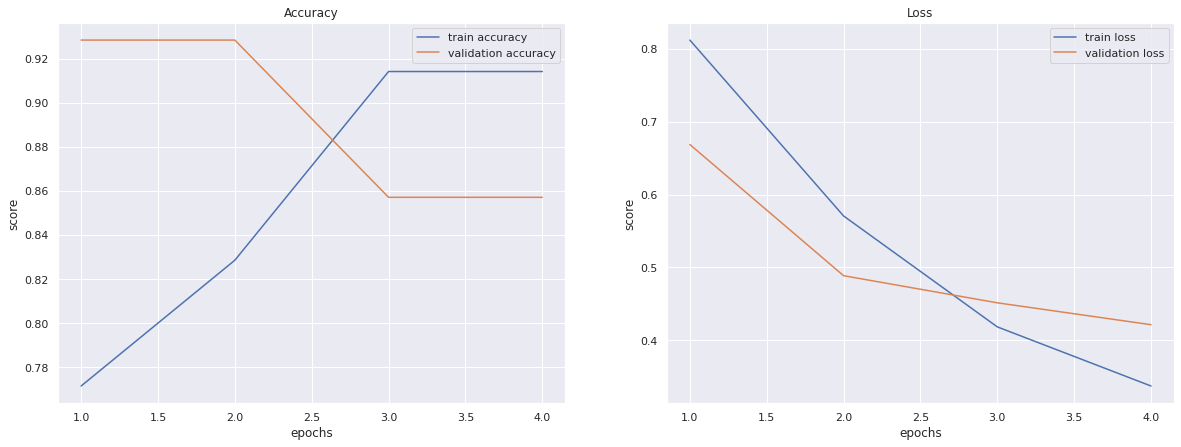

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
x_val = np.arange(1, EPOCHS + 1)
ax1.plot(x_val, history['train_acc'], label='train accuracy')
ax1.plot(x_val, history['val_acc'], label='validation accuracy')
ax2.plot(x_val, history['train_loss'], label='train loss')
ax2.plot(x_val, history['val_loss'], label='validation loss')
ax1.legend()
ax2.legend()
ax1.set(xlabel='epochs', ylabel='score', title='Accuracy')
ax2.set(xlabel='epochs', ylabel='score', title='Loss')

fig.show()

Считал все метрики у получившихся моделей в каждую эпоху, и, несмотря на такие графики, последняя получилась все же лучше остальных (особенно в плане F-score).

In [29]:
test_acc, _ = eval_model(
    clf,
    test_data_loader, 
    loss_fn,
    device
)

test_acc.item()

0.8367346525192261

In [26]:
def get_predictions(model, data_loader): 
    model = model.eval()

    records = []
    predictions = []
    real_values = []

    with torch.no_grad(): 
        for data in data_loader: 
            texts = data['record_text']
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            targets = data['targets'].to(device)

            output = model(
                input_ids=input_ids, 
                attention_mask=attention_mask
            )

            output = torch.sigmoid(output)
            output[output >= 0.5] = 1 
            output[output < 0.5] = 0 

            records.extend(texts)
            predictions.extend(output)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()

    return records, predictions, real_values

In [28]:
print(classification_report(y_test, y_pred, target_names=emotions))

              precision    recall  f1-score   support

     Позитив       0.85      0.97      0.91      1848
     Негатив       0.91      0.95      0.93      1764
Беспокойство       0.87      0.86      0.86       757
        Гнев       0.86      0.92      0.89      1414
      Грусть       0.78      0.79      0.79       865
 Уверенность       0.82      0.92      0.87      1583
    Согласие       0.94      0.92      0.93       352

   micro avg       0.85      0.92      0.89      8583
   macro avg       0.86      0.91      0.88      8583
weighted avg       0.86      0.92      0.89      8583
 samples avg       0.84      0.91      0.86      8583



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Получилось гораздо лучше, чем с RF. 

Особенно радует, что `recall` получился довольно большой (кроме грусти)